In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from keras.layers import TextVectorization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import opendatasets as od
import keras
from keras import layers
from sklearn.base import BaseEstimator
from nltk.corpus import stopwords

Here we initialize some utilities that will come useful later

In [3]:
def getStopWords()->list:
    return stopwords.words('english')

def addNegationsToken(phrase:str)->str:
    phrase = re.sub(r"n't", " not", phrase)
    transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+',
                         lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)),
                         phrase,
                         flags=re.IGNORECASE)
    return transformed

def addNegationsToData(data:pd.DataFrame)->pd.DataFrame:
    data['sentence_str'] = data['sentence_str'].apply(addNegationsToken)
    return data

We extend the `BaseEstimator` class to declare our RNN model so that we may eventually launch a Gridsearch with sklearn, if need arises.
Our architecture is constructed as a feedforward RNN with:
- An encoder, which will be a text vectorization layer.
- An embedding layer, not pretrained, of output dimension 128
- A bidirectional LSTM layer with 32 (64) units
- A dense layer with softmax activation function to get the network output.

Categorical crossentropy is used as loss function, with the Adam optimizer (which revealed itself to be the best after multiple attempts at the task)

In [4]:
class RNN(BaseEstimator):
    def __init__(self, output_units, encoder, hidden_units=100):
        self.hidden_units = hidden_units
        self.encoder = encoder
        self.model = keras.Sequential([
            self.encoder,
            layers.Embedding(
            input_dim=len(self.encoder.get_vocabulary()),
            output_dim=128),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dense(activation='softmax', units=output_units) # 13 for the number of schools
        ])
        self.model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


    def fit(
        self,
        x=None,
        y=None,
        batch_size=None,
        epochs=1,
        verbose='auto',
        callbacks=None,
        validation_split=0.0,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1
    ):
        return self.model.fit(
            x=x,
            y=y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            validation_split=validation_split,
            validation_data=validation_data,
            shuffle=shuffle,
            class_weight=class_weight,
            sample_weight=sample_weight,
            initial_epoch=initial_epoch,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            validation_batch_size=validation_batch_size,
            validation_freq=validation_freq
            )


    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, Y):
        return self.model.evaluate(X, Y)

In [5]:
od.download(
    "https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy")

Dataset URL: https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy


100%|██████████| 55.1M/55.1M [00:00<00:00, 100MB/s] 


We define the scoring functions to get the confusion matrices and infer our metrics for evaluation

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

SCHOOLS = ['analytic','aristotle','german_idealism',
           'plato','continental','phenomenology',
           'rationalism','empiricism','feminism',
           'capitalism','communism','nietzsche',
           'stoicism']

def scorePhilosophy(prediction: 'list[str]', ground_truth: 'list[str]', saveName:str=None, showConfusionMatrix:bool=False) -> None:
    cm = confusion_matrix(ground_truth, prediction, labels=SCHOOLS, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SCHOOLS)
    disp.plot()
    plt.gcf().set_size_inches(12, 12)
    plt.xticks(rotation=45)
    if saveName:
        plt.savefig(saveName, dpi=300)
    if showConfusionMatrix:
        plt.show()
    #classificaiton report
    print(classification_report(ground_truth, prediction, target_names=SCHOOLS))
    print(f"micro f1: {f1_score(ground_truth, prediction, average='micro'):.2f}")
    print(f"micro precision: {precision_score(ground_truth, prediction, average='micro'):.2f}")
    print(f"micro recall: {recall_score(ground_truth, prediction, average='micro'):.2f}")

def splitData(data:pd.DataFrame, test_size=0.25)->tuple:
    return train_test_split(data['sentence_str'], data['school'], test_size=test_size, random_state=42)

def filterShortPhrases(data:pd.DataFrame, numWords)->pd.DataFrame:
    return data[data['sentence_str'].apply(lambda x: len(x.split())>numWords)]

We define the following procedures to get the dataset, both reduced and not, ready for training and evaluation

In [7]:
# Load your datasets
def getData(validation_size:float=0.2,
            test_size:float=0.1,
            from_folder:str='',
            min_chars:int=None,
            max_chars:int=None)-> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(os.path.join(from_folder,'philosophy_data.csv'))
    development, test = train_test_split(df, test_size=test_size, stratify=df['school'], random_state=42, shuffle=True)
    #split vslidation ant train from train
    if validation_size == 0:
        return development, None, test
    train, validation = train_test_split(development,
                                         test_size=validation_size/(1 - test_size),
                                         stratify=development['school'],
                                         random_state=42,
                                         shuffle=True)

    train = reduceDataset(train, min_chars, max_chars)
    validation = reduceDataset(validation, min_chars, max_chars)
    test = reduceDataset(test, min_chars, max_chars)
    return train, validation, test

def reduceDataset(df:pd.DataFrame,
                  min_chars:int=None,
                  max_chars:int=None)-> pd.DataFrame:
    if min_chars is not None:
        df = df[(df['sentence_length'] >= min_chars)]
    if max_chars is not None:
        df = df[(df['sentence_length'] <= max_chars)]
    return df

We define two sets of training, validation and test, one with all the sentences and the other without the sentences that contain less than 85 character so that we may test our hypotheses.
We also encode the labels to facilitate training and get the set of all tokens in the dataset to feed the TextVectorization layer, which will pass its output to the embedding layer.  

In [8]:
train, validation, test = getData(from_folder = 'history-of-philosophy')
rtrain, rvalidation, rtest = getData(from_folder = 'history-of-philosophy', min_chars = 84)
df = pd.read_csv('history-of-philosophy/philosophy_data.csv')

x_train, y_train = train['sentence_str'], train['school']
x_rtrain, y_rtrain = rtrain['sentence_str'], rtrain['school']
x_val, y_val = validation['sentence_str'], validation['school']
x_rval, y_rval = rvalidation['sentence_str'], rvalidation['school']
x_test, y_test = test['sentence_str'], test['school']

lb_encoder = LabelEncoder()
y_train = lb_encoder.fit_transform(y_train)
y_train = to_categorical(y_train)
y_rtrain = lb_encoder.fit_transform(y_rtrain)
y_rtrain = to_categorical(y_rtrain)
y_val = lb_encoder.fit_transform(y_val)
y_val = to_categorical(y_val)
y_rval = lb_encoder.fit_transform(y_rval)
y_rval = to_categorical(y_rval)
y_test = lb_encoder.transform(y_test)
y_test = to_categorical(y_test)

unique_words = set()
for sentence in df['sentence_str']:
    unique_words.update(sentence.split())

encoder = TextVectorization(max_tokens=len(unique_words), output_mode='int', pad_to_max_tokens=True)
encoder.adapt(list(unique_words))

We get two models with the same architecture, one to be trained on the full dataset and the other on the reduced one.

In [9]:
rnn = RNN(output_units = 13, encoder = encoder, hidden_units = 30)
r_rnn = RNN(output_units = 13, encoder = encoder, hidden_units = 30)
rnn.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         12185600  
                                                                 
 bidirectional (Bidirection  (None, 64)                41216     
 al)                                                             
                                                                 
 dense (Dense)               (None, 13)                845       
                                                                 
Total params: 12227661 (46.64 MB)
Trainable params: 12227661 (46.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We prepare the callback and start fitting the models over their respective sets

In [10]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, save_best_only=True)]

In [11]:
history = rnn.fit(x_train, y_train, epochs = 10, batch_size = 128,  validation_data = (x_val,y_val), callbacks = callbacks)

Epoch 1/10
1974/1974 [==============================] - ETA: 0s - loss: 1.1982 - accuracy: 0.6180
Epoch 1: val_loss improved from inf to 0.85570, saving model to /tmp/ckpt/checkpoint.model.keras
1974/1974 [==============================] - 76s 36ms/step - loss: 1.1982 - accuracy: 0.6180 - val_loss: 0.8557 - val_accuracy: 0.7331
Epoch 2/10
1974/1974 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.7937
Epoch 2: val_loss improved from 0.85570 to 0.74346, saving model to /tmp/ckpt/checkpoint.model.keras
1974/1974 [==============================] - 50s 25ms/step - loss: 0.6650 - accuracy: 0.7937 - val_loss: 0.7435 - val_accuracy: 0.7663
Epoch 3/10
1974/1974 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8454
Epoch 3: val_loss improved from 0.74346 to 0.73059, saving model to /tmp/ckpt/checkpoint.model.keras
1974/1974 [==============================] - 41s 21ms/step - loss: 0.4931 - accuracy: 0.8454 - val_loss: 0.7306 - val_accuracy: 0.7744
Ep

In [12]:
history = r_rnn.fit(x_rtrain, y_rtrain, epochs = 10, batch_size = 128,  validation_data = (x_rval,y_rval),callbacks = callbacks)

Epoch 1/10
1400/1400 [==============================] - ETA: 0s - loss: 1.1906 - accuracy: 0.6242
Epoch 1: val_loss did not improve from 0.73059
1400/1400 [==============================] - 61s 41ms/step - loss: 1.1906 - accuracy: 0.6242 - val_loss: 0.7719 - val_accuracy: 0.7620
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.8237
Epoch 2: val_loss improved from 0.73059 to 0.66312, saving model to /tmp/ckpt/checkpoint.model.keras
1400/1400 [==============================] - 31s 22ms/step - loss: 0.5757 - accuracy: 0.8237 - val_loss: 0.6631 - val_accuracy: 0.7963
Epoch 3/10
1400/1400 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8805
Epoch 3: val_loss improved from 0.66312 to 0.64305, saving model to /tmp/ckpt/checkpoint.model.keras
1400/1400 [==============================] - 29s 21ms/step - loss: 0.3889 - accuracy: 0.8805 - val_loss: 0.6430 - val_accuracy: 0.8047
Epoch 4/10
1400/1400 [==============================

Having trained the model and noted that the reduced one performed better we now pass their prediction over the validation set to the scoring function we declared before and print out both the metrics and the confusion matrix

2256/2256 [==============================] - 15s 6ms/step


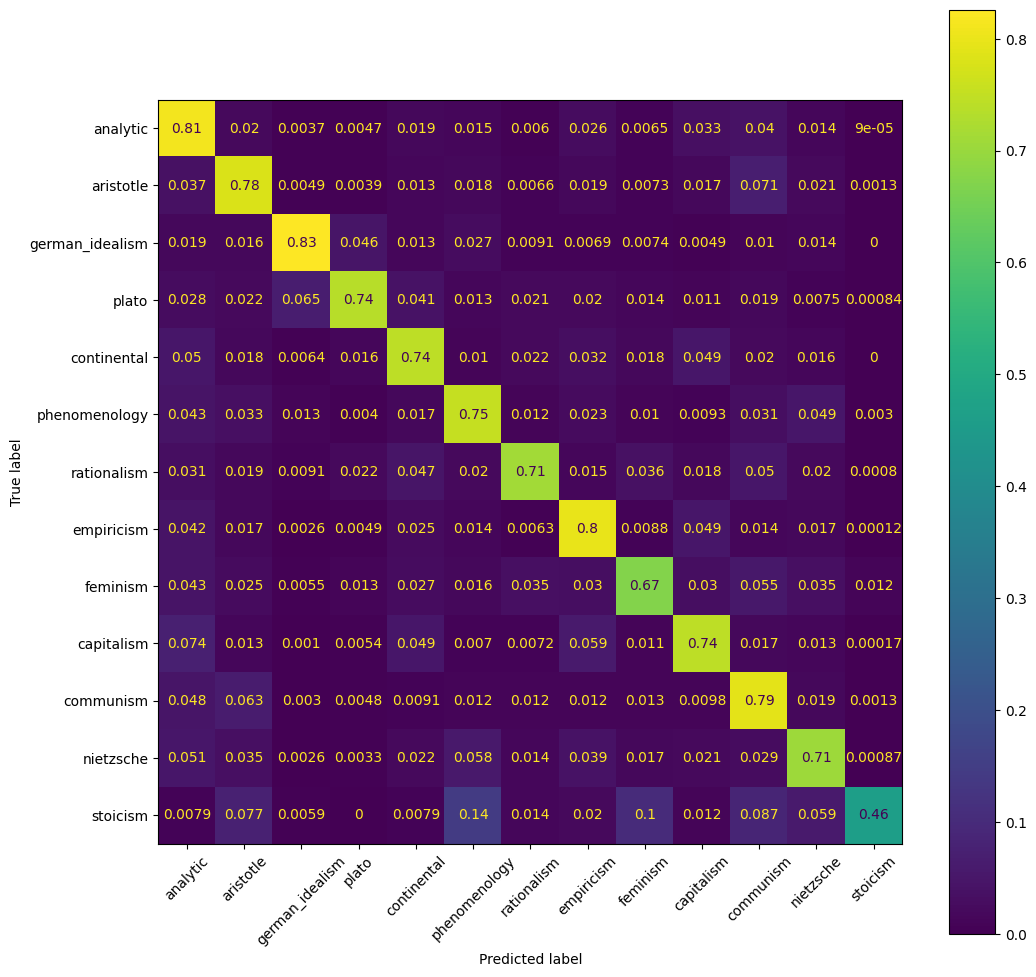

                 precision    recall  f1-score   support

       analytic       0.77      0.81      0.79     11085
      aristotle       0.82      0.78      0.80      9756
german_idealism       0.72      0.74      0.73      5715
          plato       0.73      0.79      0.76      7673
    continental       0.77      0.74      0.76      6756
  phenomenology       0.80      0.80      0.80      8427
    rationalism       0.67      0.67      0.67      2709
     empiricism       0.85      0.83      0.84      3639
       feminism       0.71      0.71      0.71      4590
     capitalism       0.70      0.75      0.73      3986
      communism       0.81      0.74      0.77      3592
      nietzsche       0.77      0.71      0.74      3727
       stoicism       0.74      0.46      0.57       507

       accuracy                           0.77     72162
      macro avg       0.76      0.73      0.74     72162
   weighted avg       0.77      0.77      0.77     72162

micro f1: 0.77
micro precisi

In [13]:
predictions = rnn.predict(x_val)
predictions = np.argmax(predictions, axis=1)
predictions = [SCHOOLS[pred] for pred in predictions]
y_val = np.argmax(y_val, axis=1)
y_val = [SCHOOLS[pred] for pred in y_val]

scorePhilosophy(predictions, y_val, "cm", True)

2256/2256 [==============================] - 14s 6ms/step


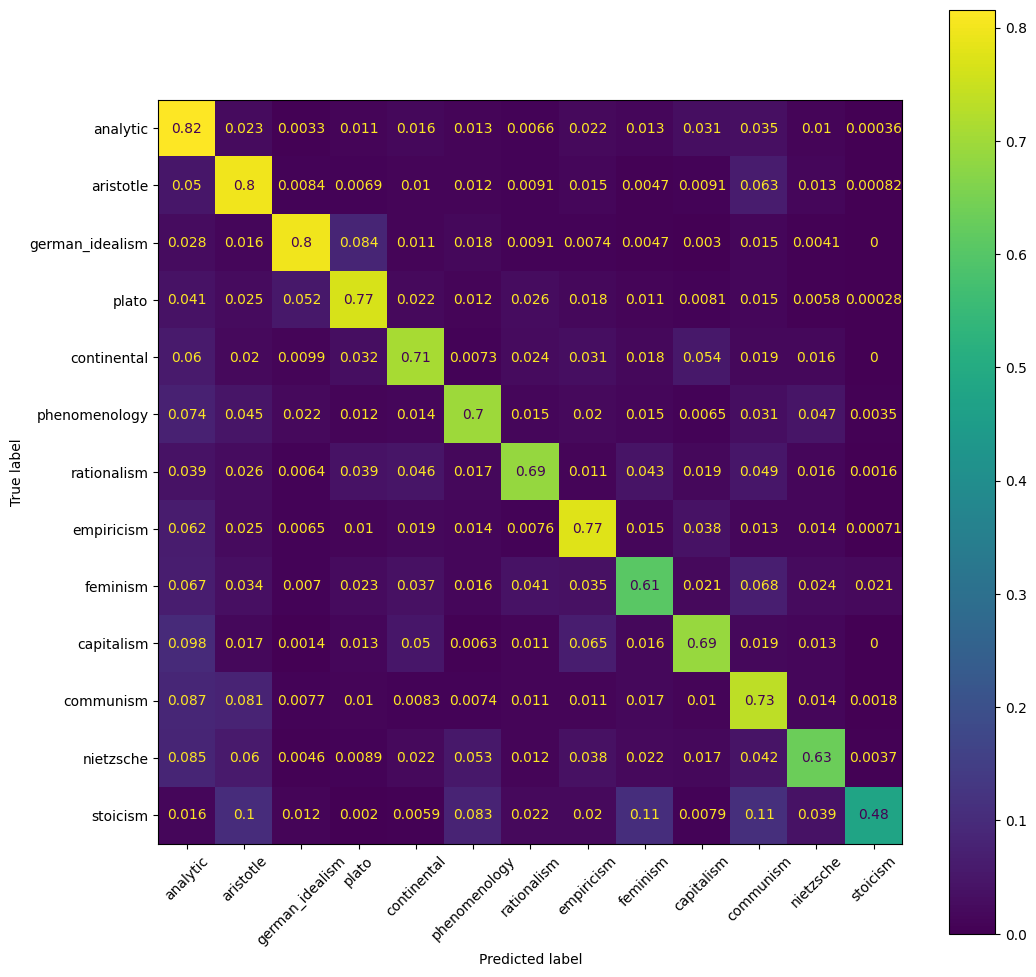

                 precision    recall  f1-score   support

       analytic       0.70      0.82      0.75     11085
      aristotle       0.78      0.80      0.79      9756
german_idealism       0.73      0.69      0.71      5715
          plato       0.72      0.73      0.73      7673
    continental       0.78      0.71      0.74      6756
  phenomenology       0.81      0.77      0.79      8427
    rationalism       0.60      0.61      0.60      2709
     empiricism       0.82      0.80      0.81      3639
       feminism       0.74      0.63      0.68      4590
     capitalism       0.73      0.70      0.71      3986
      communism       0.69      0.77      0.72      3592
      nietzsche       0.74      0.69      0.71      3727
       stoicism       0.65      0.48      0.55       507

       accuracy                           0.74     72162
      macro avg       0.73      0.71      0.72     72162
   weighted avg       0.74      0.74      0.74     72162

micro f1: 0.74
micro precisi

In [14]:
predictions = r_rnn.predict(x_val)
predictions = np.argmax(predictions, axis=1)
predictions = [SCHOOLS[pred] for pred in predictions]
# y_val = np.argmax(y_val, axis=1)
# y_val = [SCHOOLS[pred] for pred in y_val]

scorePhilosophy(predictions, y_val, "cm", True)

1601/1601 [==============================] - 10s 6ms/step


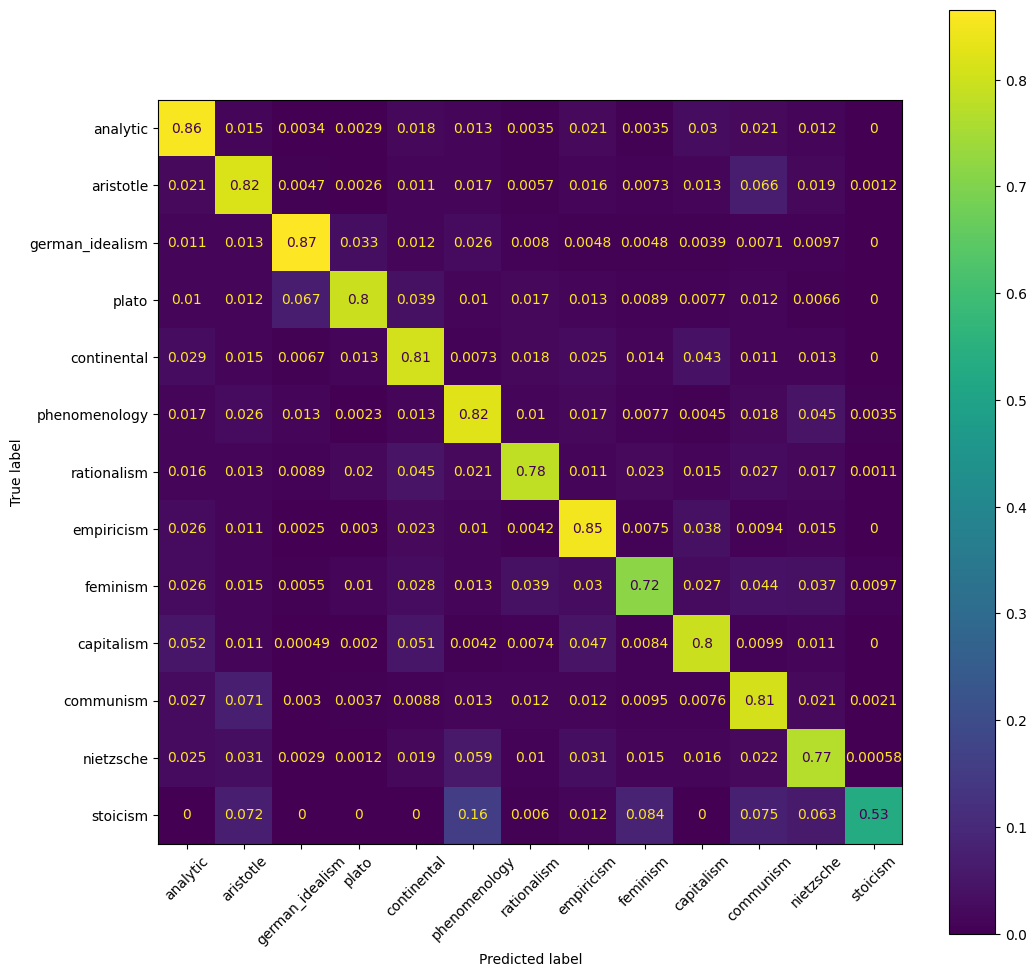

                 precision    recall  f1-score   support

       analytic       0.84      0.86      0.85      6841
      aristotle       0.86      0.82      0.84      7386
german_idealism       0.76      0.80      0.78      4049
          plato       0.76      0.81      0.78      4322
    continental       0.81      0.81      0.81      5190
  phenomenology       0.86      0.85      0.86      6668
    rationalism       0.68      0.72      0.70      1447
     empiricism       0.88      0.87      0.87      3106
       feminism       0.76      0.77      0.76      3464
     capitalism       0.76      0.82      0.79      3105
      communism       0.86      0.80      0.83      2593
      nietzsche       0.82      0.78      0.80      2702
       stoicism       0.79      0.53      0.63       333

       accuracy                           0.82     51206
      macro avg       0.80      0.79      0.79     51206
   weighted avg       0.82      0.82      0.82     51206

micro f1: 0.82
micro precisi

In [16]:
predictions = rnn.predict(x_rval)
predictions = np.argmax(predictions, axis=1)
predictions = [SCHOOLS[pred] for pred in predictions]
y_rval = np.argmax(y_rval, axis=1)
y_rval = [SCHOOLS[pred] for pred in y_rval]

scorePhilosophy(predictions, y_rval, "cm", True)

1601/1601 [==============================] - 9s 5ms/step


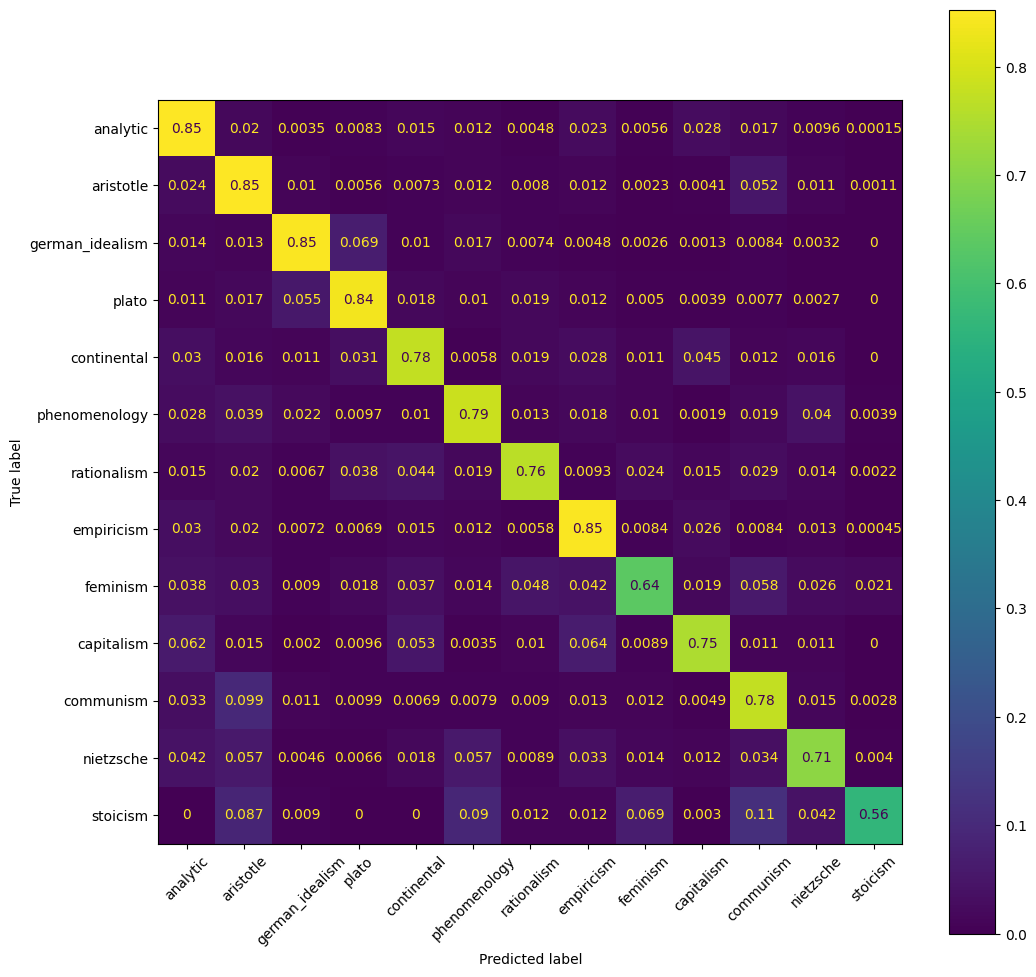

                 precision    recall  f1-score   support

       analytic       0.81      0.85      0.83      6841
      aristotle       0.82      0.85      0.84      7386
german_idealism       0.79      0.75      0.77      4049
          plato       0.75      0.78      0.77      4322
    continental       0.83      0.78      0.80      5190
  phenomenology       0.85      0.85      0.85      6668
    rationalism       0.67      0.64      0.66      1447
     empiricism       0.84      0.85      0.84      3106
       feminism       0.79      0.71      0.75      3464
     capitalism       0.77      0.79      0.78      3105
      communism       0.74      0.84      0.78      2593
      nietzsche       0.80      0.76      0.78      2702
       stoicism       0.68      0.56      0.62       333

       accuracy                           0.80     51206
      macro avg       0.78      0.77      0.77     51206
   weighted avg       0.80      0.80      0.80     51206

micro f1: 0.80
micro precisi

In [17]:
predictions = r_rnn.predict(x_rval)
predictions = np.argmax(predictions, axis=1)
predictions = [SCHOOLS[pred] for pred in predictions]
# y_val = np.argmax(y_rval, axis=1)
# y_rval = [SCHOOLS[pred] for pred in y_rval]

scorePhilosophy(predictions, y_rval, "cm", True)

In [18]:
rnn.model.save("RnnNoPretFull.keras")

In [19]:
r_rnn.model.save("RnnNoPretReduced.keras")